In [1]:
from preamble import *
from preamble import visits, systeminfo

In [2]:
def phoenix_spec2T(parameters, w, sigma, convolution_method='astropy', kernel_type='astropy'):

    T_cool = parameters['T_cool']
    T_amb = parameters['T_amb']
    f_cool = parameters['f_cool']
    
    # S_cool = get_planck_photons(wavelength=hires_wavelength,temperature = float(T_cool))
    S_cool = get_phoenix_photons(wavelength=hires_wavelength,temperature = float(T_cool), metallicity = 0.12, logg= 4.52)
    S_amb = get_phoenix_photons(wavelength=hires_wavelength,temperature = float(T_amb), metallicity = 0.12, logg= 4.52)

    # Calculate model spectrum
    _f = (f_cool*S_cool[1] + (1-f_cool)*S_amb[1])

    exclude_nans = ~np.isnan(_f)
    
    model_wave = S_cool[0].value[exclude_nans]
    model_flux = _f[exclude_nans]
    
    # Convolve and interpolate the model spectrum
    convolved = convolve_spectrum(model_wave, model_flux, sigma=sigma, method = convolution_method, kernel_type = kernel_type)
    
    # Multiply by filter response
    filter_response = visits[f'{visit}']['filter_response']
    resampled_filter_response = bintogrid(filter_response.wave[0].value, filter_response.throughput[0], newx = w.value)
    resampled_model = bintogrid(model_wave, convolved, newx = w.value)
    resampled_original_model = bintogrid(model_wave, model_flux, newx = w.value)
    
    convolved_model = resampled_model['y'] * resampled_filter_response['y']
    unconvolved_model = resampled_original_model['y'] * resampled_filter_response['y']
    
    return unconvolved_model, convolved_model

In [3]:
def btsettl_spec2T(parameters, w, sigma, convolution_method='JAX-fft', kernel_type='astropy'):
    
    T_cool = parameters['T_cool']
    T_amb = parameters['T_amb']
    f_cool = parameters['f_cool']
    
    # S_cool = get_planck_photons(wavelength=hires_wavelength,temperature = float(T_cool))[1]
    S_cool = grid(float(T_cool))
    S_amb = grid(float(T_amb))

    # Calculate model spectrum
    _f = (f_cool*S_cool + (1-f_cool)*S_amb)

    model_wave = hires_wavelength.value[:-1]
    model_flux = _f
    
    # Convolve and interpolate the model spectrum
    convolved = convolve_spectrum(model_wave, model_flux, sigma=sigma, method = convolution_method, kernel_type = kernel_type)
    
    # Multiply by filter response
    filter_response = visits[f'{visit}']['filter_response']
    resampled_filter_response = bintogrid(filter_response.wave[0].value, filter_response.throughput[0], newx = w.value)
    resampled_model = bintogrid(model_wave, convolved, newx = w.value)
    resampled_original_model = bintogrid(model_wave, model_flux, newx = w.value)
    
    convolved_model = resampled_model['y'] * resampled_filter_response['y']
    unconvolved_model = resampled_original_model['y'] * resampled_filter_response['y']
    
    return unconvolved_model, convolved_model

In [4]:
hires_wavelength = np.geomspace(0.78,2.0,10000) * u.micron
grid = get_interp_stellar_spectrum(hires_wavelength.value)

In [15]:
from scipy.signal import correlate
import astropy.constants as con

def wavelength_to_velocity(wavelength):
    """ Convert wavelength to velocity relative to a reference wavelength. """
    ref_wavelength = np.nanmean(wavelength)
    vspace = con.c * ((wavelength - ref_wavelength) / ref_wavelength)
    
    return vspace

def cross_correlate_spectra(wavelength_obs, flux_obs, flux_model):
    """ Cross-correlate two spectra and return the velocity shift with the best match. """
    
    # Convert the wavelength grids into velocity space
    velocity_obs = wavelength_to_velocity(wavelength_obs)
    
    # We assume that the velocity spacing is uniform for simplicity
    delta_v = np.nanmedian(velocity_obs[1:] - velocity_obs[:-1])
    
    # Perform the cross-correlation
    corr = correlate(flux_obs, flux_model, mode='full',method='direct')
    
    # Find the lag that gives the maximum correlation
    lag_max = np.argmax(corr)
    
    # Convert the lag into a velocity shift
    velocity_shift = (delta_v * (lag_max-len(flux_obs)/2.0)).to('km/s')

    # plt.plot(velocity_obs,flux_obs,flux_model)

    # print(f"Velocity obs: {velocity_obs[:10]}")
    # print(f"Delta v: {delta_v}")
    # print(f'Delta lambda: {wavelength_obs[1:]-wavelength_obs[:-1]}')
    # print(f"Lag max: {lag_max}")
    # print(f"Corr shape: {corr.shape}")
    
    return velocity_shift, corr

In [6]:
for visit in ['F21','S22']:
    
    for direction in ['Forward','Backward']:

        print(visit,direction)
        print('')

        grismname = visits[f'{visit}']['Grism']
        trimmed_rainbow = read_rainbow(f'../data/{visit}_{direction}_trimmed.rainbow.npy')#.shift(velocity=-1500*u.km/u.s)
        w = trimmed_rainbow.wavelength
        average_spectrum = trimmed_rainbow.get_average_spectrum()
        average_error = 100e-6 * average_spectrum

        sigma = visits[f'{visit}']['filter_sigma']
        filter_response = visits[f'{visit}']['filter_response']

        'Continuum-normalize the data'
        contin_normed_data = continuum_correction(w,average_spectrum)

        'Set up spot params and calculate spot models'
        parameters = lmfit.Parameters()
        # Spotted spectrum parameters
        parameters.add('f_cool', value=0.39, min=0,max=1.0,vary=True)
        parameters.add('T_cool', value=3100, min=2300, max=3650, vary=True)
        parameters.add('T_amb', value=4000, min=3650, max=5000, vary=True)

        phoenixmodel,phconv_model = phoenix_spec2T(parameters, w, sigma)
        btsettlmodel,btconv_model = btsettl_spec2T(parameters, w, sigma)

        contin_normed_phoenix_model = continuum_correction(w,phconv_model)
        contin_normed_btsettl_model = continuum_correction(w,btconv_model)

        'Set up unspotted model params and calculate models'
        p_no_spot = lmfit.Parameters()
        # Spotted spectrum parameters
        p_no_spot.add('f_cool', value=0, min=0,max=1.0,vary=True)
        p_no_spot.add('T_cool', value=3000, vary = False)
        p_no_spot.add('T_amb', value=3700, vary = False)

        singleTphmodel,singleTphconv_model = phoenix_spec2T(p_no_spot, w, sigma)
        singleTbtmodel,singleTbtconv_model = btsettl_spec2T(p_no_spot, w, sigma)

        contin_normed_1Tphoenix_model = continuum_correction(w,singleTphconv_model)
        contin_normed_1Tbtsettl_model = continuum_correction(w,singleTbtconv_model)

        'Cross-correlate models with data and calculate a best-fit velocity shift'
        velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_1Tphoenix_model)
        print(f"Best velocity shift (PHOENIX 1T): {velocity_shift}")
        velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_phoenix_model)
        print(f"Best velocity shift (PHOENIX 2T): {velocity_shift}")
        velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_1Tbtsettl_model)
        print(f"Best velocity shift (BT-SETTL 1T): {velocity_shift}")
        velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_btsettl_model)
        print(f"Best velocity shift (BT-SETTL 2T): {velocity_shift}")

F21 Forward



  0%|          | 0/103 [00:00<?, ?it/s]

Best velocity shift (PHOENIX 1T): 51354.263087810534 km / s
Best velocity shift (PHOENIX 2T): 51354.263087810534 km / s
Best velocity shift (BT-SETTL 1T): 51354.263087810534 km / s
Best velocity shift (BT-SETTL 2T): 51354.263087810534 km / s
F21 Backward



  0%|          | 0/105 [00:00<?, ?it/s]

Best velocity shift (PHOENIX 1T): 51286.66710503529 km / s
Best velocity shift (PHOENIX 2T): 51286.66710503529 km / s
Best velocity shift (BT-SETTL 1T): 51286.66710503529 km / s
Best velocity shift (BT-SETTL 2T): 51286.66710503529 km / s
S22 Forward



  0%|          | 0/120 [00:00<?, ?it/s]

Best velocity shift (PHOENIX 1T): 44144.15469044851 km / s
Best velocity shift (PHOENIX 2T): 44144.15469044851 km / s
Best velocity shift (BT-SETTL 1T): 44144.15469044851 km / s
Best velocity shift (BT-SETTL 2T): 44144.15469044851 km / s
S22 Backward



  0%|          | 0/120 [00:00<?, ?it/s]

Best velocity shift (PHOENIX 1T): 44144.15469044851 km / s
Best velocity shift (PHOENIX 2T): 44144.15469044851 km / s
Best velocity shift (BT-SETTL 1T): 44144.15469044851 km / s
Best velocity shift (BT-SETTL 2T): 44144.15469044851 km / s


F21 Forward



  0%|          | 0/103 [00:00<?, ?it/s]

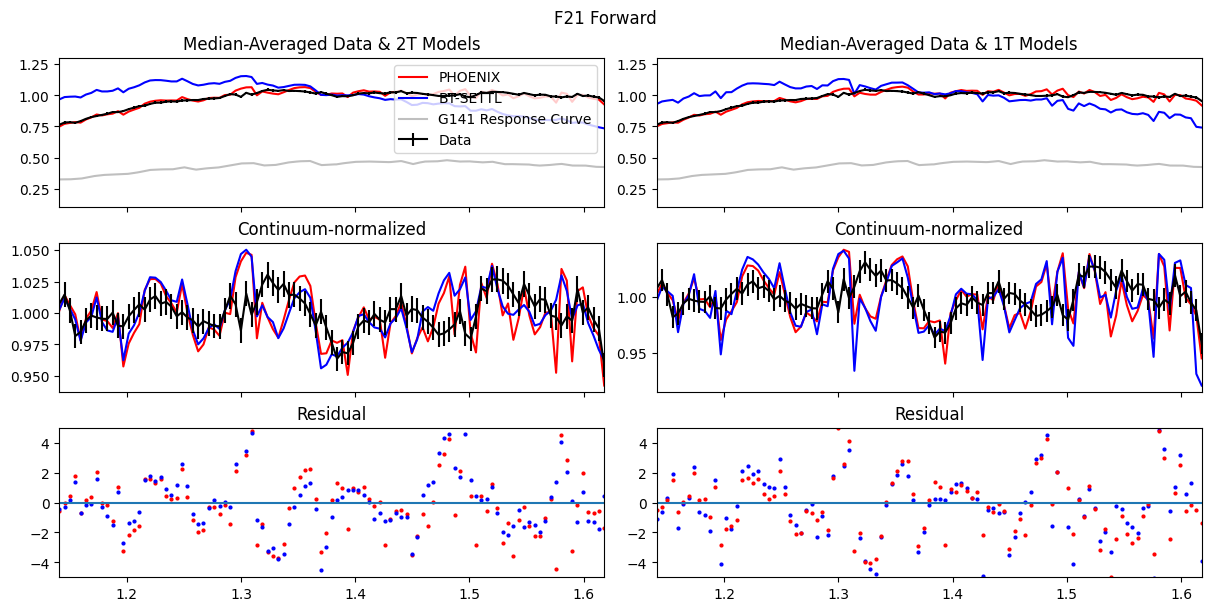

reduced chisq, 1T PHOENIX: 4.354495157643165
reduced chisq, 2T PHOENIX: 4.361516832527775
reduced chisq, 1T BT-SETTL: 5.815880447147537
reduced chisq, 2T BT-SETTL: 3.776077470969341
F21 Backward



  0%|          | 0/105 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

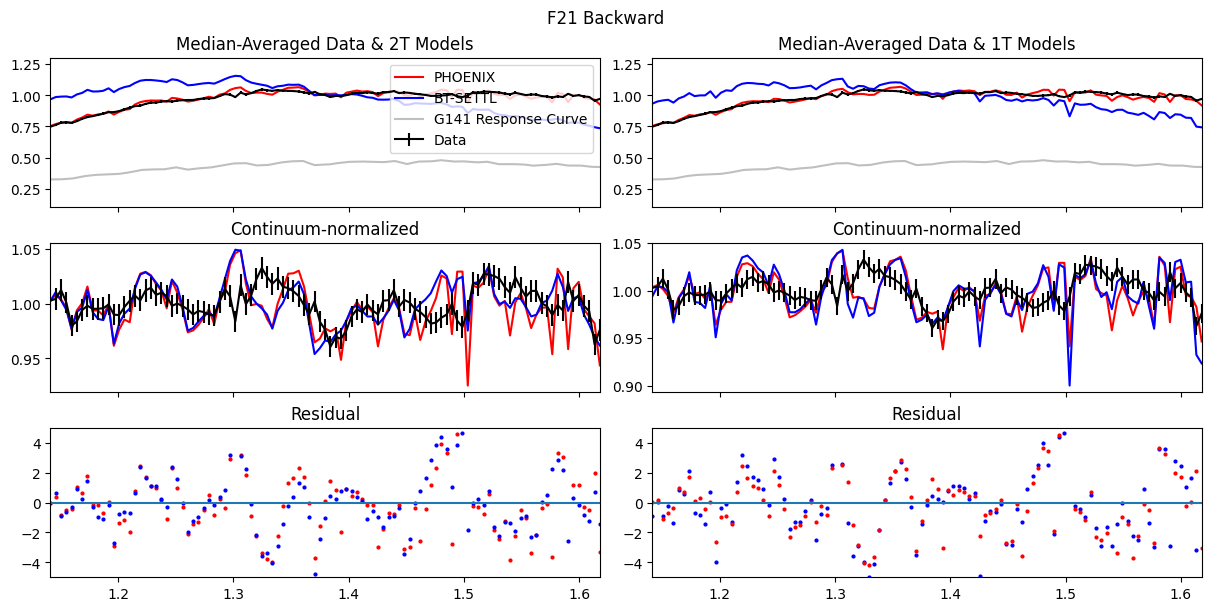

reduced chisq, 1T PHOENIX: 4.847409103081668
reduced chisq, 2T PHOENIX: 5.025426463443975
reduced chisq, 1T BT-SETTL: 5.718690849742984
reduced chisq, 2T BT-SETTL: 3.7677177956792764
S22 Forward



  0%|          | 0/120 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

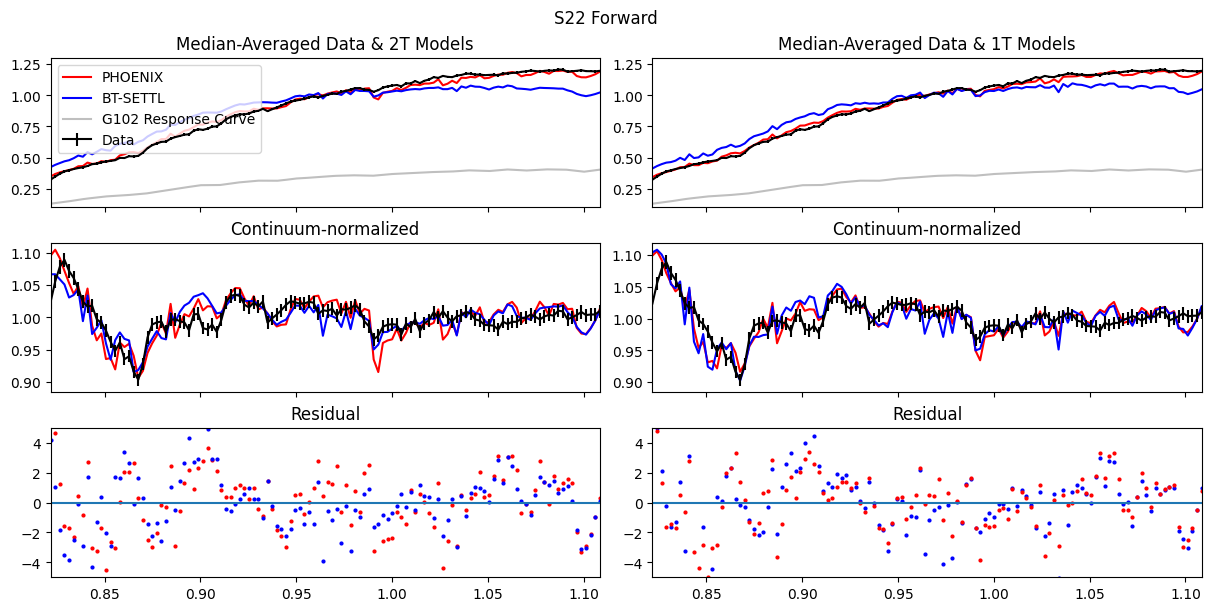

reduced chisq, 1T PHOENIX: 3.8077484694377692
reduced chisq, 2T PHOENIX: 4.368557264686972
reduced chisq, 1T BT-SETTL: 4.801513646571488
reduced chisq, 2T BT-SETTL: 3.6168023848618898
S22 Backward



  0%|          | 0/120 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

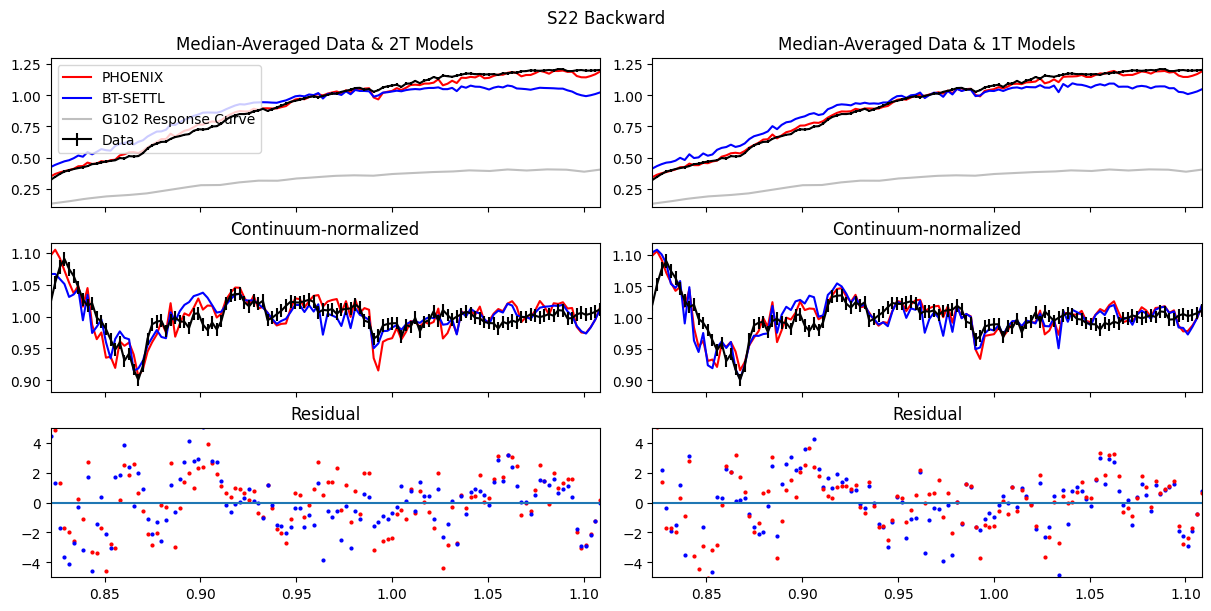

reduced chisq, 1T PHOENIX: 3.8442450662237655
reduced chisq, 2T PHOENIX: 4.373245920587351
reduced chisq, 1T BT-SETTL: 4.8352288728829045
reduced chisq, 2T BT-SETTL: 3.6539998543910728


<Figure size 640x480 with 0 Axes>

In [20]:
for visit in ['F21','S22']:
    
    for direction in ['Forward','Backward']:

        print(visit,direction)
        print('')

        grismname = visits[f'{visit}']['Grism']
        if visit == 'F21':
            trimmed_rainbow = read_rainbow(f'../data/{visit}_{direction}_trimmed.rainbow.npy').shift(velocity=2000*u.km/u.s)
        else:
            trimmed_rainbow = read_rainbow(f'../data/{visit}_{direction}_trimmed.rainbow.npy')#.shift(velocity=1500*u.km/u.s)
        w = trimmed_rainbow.wavelength
        average_spectrum = trimmed_rainbow.get_average_spectrum()
        # average_error = 100e-6 * average_spectrum

        sigma = visits[f'{visit}']['filter_sigma']
        filter_response = visits[f'{visit}']['filter_response']

        'Continuum-normalize the data'
        contin_normed_data = continuum_correction(w,average_spectrum)

        'Set up spot params and calculate spot models'
        parameters = lmfit.Parameters()
        # Spotted spectrum parameters
        parameters.add('f_cool', value=0.39, min=0,max=1.0,vary=True)
        parameters.add('T_cool', value=3100, min=2300, max=3650, vary=True)
        parameters.add('T_amb', value=4000, min=3650, max=5000, vary=True)

        phoenixmodel,phconv_model = phoenix_spec2T(parameters, w, sigma)
        btsettlmodel,btconv_model = btsettl_spec2T(parameters, w, sigma)

        contin_normed_phoenix_model = continuum_correction(w,phconv_model)
        contin_normed_btsettl_model = continuum_correction(w,btconv_model)

        'Set up unspotted model params and calculate models'
        p_no_spot = lmfit.Parameters()
        # Spotted spectrum parameters
        p_no_spot.add('f_cool', value=0, min=0,max=1.0,vary=True)
        p_no_spot.add('T_cool', value=3000, vary = False)
        p_no_spot.add('T_amb', value=3700, vary = False)

        singleTphmodel,singleTphconv_model = phoenix_spec2T(p_no_spot, w, sigma)
        singleTbtmodel,singleTbtconv_model = btsettl_spec2T(p_no_spot, w, sigma)

        contin_normed_1Tphoenix_model = continuum_correction(w,singleTphconv_model)
        contin_normed_1Tbtsettl_model = continuum_correction(w,singleTbtconv_model)

        # 'Cross-correlate models with data and calculate a best-fit velocity shift'
        # velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_1Tphoenix_model)
        # print(f"Best velocity shift (PHOENIX 1T): {velocity_shift}")
        # velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_phoenix_model)
        # print(f"Best velocity shift (PHOENIX 2T): {velocity_shift}")
        # velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_1Tbtsettl_model)
        # print(f"Best velocity shift (BT-SETTL 1T): {velocity_shift}")
        # velocity_shift, correlation = cross_correlate_spectra(w, contin_normed_data, contin_normed_btsettl_model)
        # print(f"Best velocity shift (BT-SETTL 2T): {velocity_shift}")
        
        fig, axs = plt.subplots(3,2, figsize=(12,6), sharex=True)
        ax11 = axs[0,0]
        ax12 = axs[0,1]
        ax21 = axs[1,0]
        ax22 = axs[1,1]
        ax31 = axs[2,0]
        ax32 = axs[2,1]

        fig.suptitle(f'{visit} {direction}')

        ax11.set_title('Median-Averaged Data & 2T Models')
        ax11.errorbar(w, average_spectrum/np.nanmedian(average_spectrum),yerr=(0.01*contin_normed_data),label='Data',color='k',zorder=1000)
        ax11.plot(w, phconv_model/np.nanmedian(phconv_model),label='PHOENIX',color='r')
        ax11.plot(w, btsettlmodel/np.nanmedian(btsettlmodel),label='BT-SETTL',color='b')
        ax11.plot(filter_response.wave.value[0],filter_response.throughput[0],label=f'{grismname} Response Curve',color='gray',zorder=-100,alpha=0.5)
        ax11.legend()
        ax11.set_ylim(0.1,1.3)

        ax12.set_title('Median-Averaged Data & 1T Models')
        ax12.errorbar(w, average_spectrum/np.nanmedian(average_spectrum),yerr=(0.01*contin_normed_data),label='Data',color='k',zorder=1000)
        ax12.plot(w, singleTphconv_model/np.nanmedian(singleTphconv_model),label='PHOENIX',color='r')
        ax12.plot(w, singleTbtmodel/np.nanmedian(singleTbtmodel),label='BT-SETTL',color='b')
        ax12.plot(filter_response.wave.value[0],filter_response.throughput[0],label=f'{grismname} Response Curve',color='gray',zorder=-100,alpha=0.5)
        ax12.set_ylim(0.1,1.3)

        ax21.set_title('Continuum-normalized')
        ax21.errorbar(w,contin_normed_data,label='Data',yerr=(0.01*contin_normed_data),color='k',zorder=1000)
        ax21.plot(w,contin_normed_phoenix_model,label='PHOENIX',color='r')
        ax21.plot(w,contin_normed_btsettl_model,label='BT-SETTL',color='b')

        ax22.set_title('Continuum-normalized')
        ax22.errorbar(w,contin_normed_data,yerr=(0.01*contin_normed_data),color='k',zorder=1000)
        ax22.plot(w,contin_normed_1Tphoenix_model,label='PHOENIX',color='r')
        ax22.plot(w,contin_normed_1Tbtsettl_model,label='BT-SETTL',color='b')

        ax31.set_title('Residual')
        ax31.scatter(w,(contin_normed_phoenix_model-contin_normed_data)/(0.01*contin_normed_data),color='r',s=4)
        ax31.scatter(w,(contin_normed_btsettl_model-contin_normed_data)/(0.01*contin_normed_data),color='b',s=4)
        ax31.axhline(0)
        ax31.set_ylim(-5,5)

        ax32.set_title('Residual')
        ax32.scatter(w,(contin_normed_1Tbtsettl_model-contin_normed_data)/(0.01*contin_normed_data),color='b',s=4)
        ax32.scatter(w,(contin_normed_1Tphoenix_model-contin_normed_data)/(0.01*contin_normed_data),color='r',s=4)
        ax32.axhline(0)
        ax32.set_ylim(-5,5)

        ax32.set_xlim(w.value[0],w.value[-1])
        plt.savefig(f'../figs/{visit}_{direction}_modelcomparisons.png')
        plt.show()
        plt.clf()

        residual = (contin_normed_1Tphoenix_model-contin_normed_data)/(0.01*contin_normed_data)
        rchisq = np.nansum(residual**2)/(len(contin_normed_data)-1)
        print(f'reduced chisq, 1T PHOENIX: {rchisq}')
        
        residual = (contin_normed_phoenix_model-contin_normed_data)/(0.01*contin_normed_data)
        rchisq = np.nansum(residual**2)/(len(contin_normed_data)-3)
        print(f'reduced chisq, 2T PHOENIX: {rchisq}')
        
        residual = (contin_normed_1Tbtsettl_model-contin_normed_data)/(0.01*contin_normed_data)
        rchisq = np.nansum(residual**2)/(len(contin_normed_data)-1)
        print(f'reduced chisq, 1T BT-SETTL: {rchisq}')
        
        residual = (contin_normed_btsettl_model-contin_normed_data)/(0.01*contin_normed_data)
        rchisq = np.nansum(residual**2)/(len(contin_normed_data)-3)
        print(f'reduced chisq, 2T BT-SETTL: {rchisq}')

In [10]:
for visit in ['F21','S22']:
        
    for direction in ['Forward','Backward']:

        print('Running ',visit,direction)
        print('')

        ################################################################
        'INITIALIZE DATA AND MODELS' ###################################
        
        'Extract exposure times and mid-transit times from the dictionary'
        predicted_T0 = visits[f'{visit}']['T0 (BJD_TDB)']
        expTime = visits[f'{visit}']['exp (s)'].value
        sigma = visits[f'{visit}']['filter_sigma']

        'Read WFC3 spectral data'
        trimmed_r = read_rainbow(f'../data/{visit}_{direction}_trimmed.rainbow.npy')
        data_wave = trimmed_r.wavelength
        data_flux = trimmed_r.get_average_spectrum()
        data_err = 100e-6 * data_flux

        ################################################################
        'DEFINE MODEL PARAMETERS IN LMFIT' #############################
        parameters = lmfit.Parameters()
        # Spotted spectrum parameters
        parameters.add('f_cool', value=0.3, min=0,max=1.0,vary=True)
        parameters.add('T_cool', value=3000, min=2300, max=3650, vary=True)
        parameters.add('T_amb', value=4000, min=3650, max=5000, vary=True)
        
        ################################################################
        'SET UP AND RUN LMFIT MINIMIZER' ###############################
        
        minimizer = lmfit.Minimizer(residual, parameters, fcn_args=(data_wave, data_flux, sigma))
        result = minimizer.minimize()
        print(result.params)

        ################################################################
        'CALCULATE BEST-FIT MODELS FROM THE MINIMIZER' #################

        'Calculate Model'
        _,observed_phoenix_model = phoenix_spec2T(result.params, w, sigma)
        _,observed_btsettl_model = btsettl_spec2T(result.params, w, sigma)

        ################################################################
        'PLOT BEST FIT MODELS FROM THE MINIMIZER' ######################

        fig, [ax1,ax2,ax3] = plt.subplots(6,1,figsize=(6,12),sharex=True)
        fig.suptitle(f'{visit} with Optimized Model')
        
        ax1.errorbar(w,data_flux,yerr=data_err,label='WFC3 White Light Curve',color='k',zorder=-100)
        ax1.plot(w,observed_phoenix_model,label='PHOENIX Model',color='red')
        ax1.plot(w,observed_btsettl_model,label='BT-SETTL Model',color='blue')
        ax1.legend()
                
        ax2.plot(w, (data_flux-observed_phoenix_model)/data_err, color='red')
        ax2.plot(w, (data_flux-observed_btsettl_model)/data_err, color='blue')
        ax2.legend()
        
        plt.savefig(f'../figs/{visit}_{direction}_optimized_models.png')
        plt.show()
        plt.clf()
        ################################################################        'RE-RUN FITS WITH THESE PARAMS AND AN ADDITIONAL SINUSOIDAL BASELINE TERM' ############
        
        # Use the result to set up MCMC
        emcee_kws = dict(steps=20000, burn=5000, nwalkers=150, is_weighted=True, progress=True)
        result_emcee = minimizer.emcee(params=result.params, **emcee_kws)
        
        # Extract the MCMC results
        emcee_params = result_emcee.params
        
        # Print the parameter results
        for name, param in emcee_params.items():
            print(f'{name}: {param.value:.4f} ± {param.stderr:.4f}')

        ################################################################
        'CALCULATE BEST FIT MODELS FROM EMCEE'##########################

        'Set circum-gap values as nan to get rid of lines in the plots, '
        ' and re-calcuate light curves'
        for j in range(len(img_date)):
            if j >= 1:
                if (time_in_seconds[j] - time_in_seconds[j - 1]) > 1e3:
                    trimmed_r.flux[:,j] = np.nan
                    trimmed_r.flux[:,j-1] = np.nan
                    trimmed_r.uncertainty[:,j] = np.nan
                    trimmed_r.uncertainty[:,j-1] = np.nan
                    trimmed_r.time[j] = np.nan
                    trimmed_r.time[j-1] = np.nan
        white_light_curve = np.nansum(trimmed_r.flux*dw, axis=0)
        data_flux = white_light_curve/len(trimmed_r.wavelength.value) #dividing by the length of the wavelength array to arrive at a more realistic value of electron counts that will maybe play nicer with RECTE
        data_err = np.sqrt(white_light_curve)/len(trimmed_r.wavelength.value)
        
        ################################################################
        'PLOT BEST FIT MODELS FROM EMCEE'###############################
        
        fig, [ax1,ax2,ax3,ax3p5,ax4,ax5] = plt.subplots(6,1,figsize=(6,12),sharex=True)
        fig.suptitle(f'{visit} {direction} MCMC Results')
        
        ax1.errorbar(img_date,data_flux,yerr=data_err,
                 label='WFC3 White Light Curve',alpha=0.5,color='k')
        ax1.plot(img_date,observed_flux_model,label='Max Likelihood Model',color='red',zorder=100)
        ax1.set_ylabel('e-')
        ax1.legend()
        
        ax2.plot(img_date,ramp,label='RECTE Model')
        ax2.set_ylabel('e-')
        ax2.legend()
        
        ax3.plot(img_date,transit,label='Transit Model')
        ax3.set_ylim(0.992,1.004)
        ax3.set_ylabel('Relative Flux')
        ax3.legend()

        ax3p5.plot(img_date,baseline,label='Stellar Baseline Model')
        ax3p5.legend()
        
        ax4.errorbar(img_date, data_flux/(ramp*baseline), yerr = data_err/(ramp*baseline),alpha=0.5,zorder=-100,color='k')
        ax4.plot(img_date, transit,label='Transit Model',alpha=1,zorder=100,color='red')
        ax4.set_ylabel('Relative Flux')
        ax4.set_ylim(0.992,1.004)
        ax4.legend()
        
        ax5.scatter(img_date, (data_flux-observed_flux_model)/data_err, label = 'Residuals')
        ax5.axhline(0)
        ax5.set_ylim(-4,4)
        ax5.set_ylabel(r'$\sigma$')
        ax5.legend()
        
        plt.savefig(f'../figs/{visit}_{direction}_emcee_models_withbaseline.png')
        plt.show()
        plt.clf()

        ####################################################

Running  F21 Forward



  0%|          | 0/103 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (0,) (103,) 

In [34]:
# hires_wavelength = np.geomspace(0.77,2.0,10000) * u.micron
# grid = get_interp_stellar_spectrum(hires_wavelength.value)

# for visit in ['F21','S22']:
    
#     for direction in ['Forward','Backward']:

#         print(visit,direction)
#         print('')

#         grismname = visits[f'{visit}']['Grism']
#         trimmed_rainbow = read_rainbow(f'../data/{visit}_{direction}_trimmed.rainbow.npy')
#         average_spectrum = trimmed_rainbow.get_average_spectrum()
#         average_error = np.sum(trimmed_rainbow.uncertainty, axis = 1)/np.sqrt(len(trimmed_rainbow.time))
#         sigma = visits[f'{visit}']['filter_sigma']
#         filter_response = visits[f'{visit}']['filter_response']

#         parameters = lmfit.Parameters()
#         parameters.add('f_cool', value=0.3, min=0,max=1.0,vary=True)
#         parameters.add('T_cool', value=3000, min=2300, max=3650, vary=True)
#         parameters.add('T_amb', value=4000, min=3650, max=5000, vary=True)
        
#         w = trimmed_rainbow.wavelength

#         fig, axs = plt.subplots(2,2, figsize=(10,8),sharex=True,sharey=True)

#         model_1,conv_1 = phoenix_spec2T(parameters, w, sigma, convolution_method='JAX-fft',kernel_type = 'astropy')
#         model_2,conv_2 = phoenix_spec2T(parameters, w, sigma, convolution_method='JAX-fft',kernel_type = 'calculated')
#         model_3,conv_3 = phoenix_spec2T(parameters, w, sigma, convolution_method='astropy-fft',kernel_type = 'astropy')
#         model_4,conv_4 = phoenix_spec2T(parameters, w, sigma, convolution_method='astropy-fft',kernel_type = 'calculated')

#         # column 0 ([0,:]) is the astropy defined kernels
#         # column 1 ([1,:]) is the manually-defined kernels

#         # Row 0 is JAX FFT convolution
#         # Row 1 is astropy FFT
#         fig.suptitle(f'{visit} {direction} | Sigma = {sigma.value}')

#         axs[0,0].plot(w,model_1/np.nanmedian(model_1),label='Input Model')
#         axs[0,0].plot(w,conv_1/np.nanmedian(conv_1),label='Convolution')
#         axs[0,0].legend()
        
#         axs[0,1].plot(w,model_2/np.nanmedian(model_2),label='Input Model')
#         axs[0,1].plot(w,conv_2/np.nanmedian(conv_2),label='Convolution')

#         axs[1,0].plot(w,model_3/np.nanmedian(model_3),label='Input Model')
#         axs[1,0].plot(w,conv_3/np.nanmedian(conv_3),label='Convolution')
        
#         axs[1,1].plot(w,model_4/np.nanmedian(model_4),label='Input Model')
#         axs[1,1].plot(w,conv_4/np.nanmedian(conv_4),label='Convolution')

#         for ax in axs.flatten():
#             ax.plot(w, average_spectrum/np.nanmedian(average_spectrum),label='Median-averaged Data',color='k',ls='--')

#         # plt.savefig('.png')
#         plt.show()
#         plt.clf()